### BG/NBD to predict the frequency

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from lifetimes import ModifiedBetaGeoFitter
from decimal import Decimal 
import datetime as dt


In [3]:
df = pd.read_csv('online_retail.csv', encoding='ISO-8859-1')
# df.Country.value_counts()
# df.drop('Unnamed: 0', inplace=True, axis=1)
df = df[df['Country'] == 'United Kingdom']

In [4]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133600
Country             0
dtype: int64

In [5]:
df.dropna(inplace=True)

In [6]:
# Dropping rows with negative quantity.
df = df[~df['Quantity'] < 0]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354345 entries, 0 to 541893
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    354345 non-null  object 
 1   StockCode    354345 non-null  object 
 2   Description  354345 non-null  object 
 3   Quantity     354345 non-null  int64  
 4   InvoiceDate  354345 non-null  object 
 5   UnitPrice    354345 non-null  float64
 6   CustomerID   354345 non-null  float64
 7   Country      354345 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 24.3+ MB


In [7]:
# Setting data types 
df['InvoiceNo'] = df['InvoiceNo'].astype('str')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['CustomerID'] = df['CustomerID'].astype('str')
df['Description'] = df['Description'].astype('str')
df['StockCode'] = df['StockCode'].astype('str')
df['Country'] = df['Country'].astype('str')
df['UnitPrice'] = df['UnitPrice'].apply(Decimal)

In [8]:
# Creating the monetary value of the transactions (quantity * price)
df['Monetary'] = df['Quantity'] * df['UnitPrice']
df['Monetary'] = df['Monetary'].apply(Decimal) 

Some validation over frequency

In [9]:
df[df['CustomerID'] == '12820.0'].groupby('InvoiceDate').size()

InvoiceDate
2011-01-17 12:34:00    11
2011-09-26 11:49:00    14
2011-10-26 13:27:00    22
2011-12-06 15:12:00    12
dtype: int64

some validation over monetary

In [10]:
# Group transactions by CustomerID and InvoiceDate
grouped = df.groupby(['CustomerID', 'InvoiceDate']).agg({'Monetary': 'sum'}).reset_index()

# Filter for the specific customer
customer_transactions = grouped[grouped['CustomerID'] == '12820.0']


# Exclude the first transaction
repeat_transactions = customer_transactions.iloc[1:]  # Drop the first row

# Calculate the average monetary value for repeat transactions
average_monetary_value = repeat_transactions['Monetary'].mean()

print("Average Monetary Value:", average_monetary_value)

Average Monetary Value: 257.29333333333335


In [11]:
# Computing the summary data (Recency, Frequency, monetary and tenure)
df_rfmt = summary_data_from_transaction_data(transactions = df, 
                                         customer_id_col = 'CustomerID', 
                                         datetime_col = 'InvoiceDate', 
                                         monetary_value_col = 'Monetary')
df_rfmt.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,325.0,0.000000
12747.0,10.0,367.0,369.0,383.745000
12748.0,113.0,373.0,373.0,298.360885
12749.0,3.0,210.0,213.0,1077.260000
12820.0,3.0,323.0,326.0,257.293333


In [12]:
# size of the data 
diff_time = df['InvoiceDate'].max() - df['InvoiceDate'].min() 
diff_time

Timedelta('373 days 04:23:00')

In [13]:
# Getting the ending date of the calibration period. 
end_date_cal = df['InvoiceDate'].min() + dt.timedelta(days=200)
end_date_obs = end_date_cal + (diff_time - dt.timedelta(days=200))

In [14]:
df_rfmt_cal = calibration_and_holdout_data(transactions=df, 
                                          customer_id_col="CustomerID",
                                          datetime_col = "InvoiceDate", 
                                          calibration_period_end=end_date_cal,
                                          observation_period_end= end_date_obs)
df_rfmt_cal

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12346.0,0.0,0.0,152.0,0.0,173.0
12747.0,5.0,171.0,196.0,5.0,173.0
12748.0,46.0,198.0,200.0,67.0,173.0
12749.0,0.0,0.0,40.0,3.0,173.0
12820.0,0.0,0.0,153.0,3.0,173.0
...,...,...,...,...,...
18273.0,0.0,0.0,84.0,2.0,173.0
18280.0,0.0,0.0,104.0,0.0,173.0
18281.0,0.0,0.0,7.0,0.0,173.0


In [15]:
l2_coefs = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
l2_list = []
rmse_list = []
for coef in l2_coefs :
    # Fitting the model using the calibration dataset.
    model = BetaGeoFitter(penalizer_coef=coef)
    model.fit(df_rfmt_cal['frequency_cal'], 
        df_rfmt_cal['recency_cal'], 
        df_rfmt_cal['T_cal'])
    # Predicting the frequency for the holdout period for all customers. 
    pred_freq = pd.DataFrame(model.predict(df_rfmt_cal['duration_holdout'], 
                                 df_rfmt_cal['frequency_cal'], df_rfmt_cal['recency_cal'], df_rfmt_cal['T_cal']), columns=['pred_frequency']).reset_index()
    # Merging the two dataframes and dropping NaN values. 
    new_df = df_rfmt_cal.reset_index().merge(pred_freq, on='CustomerID').dropna()

    # Computing the rmse score 
    rmse_score = np.sqrt(mean_squared_error(new_df['frequency_holdout'],new_df['pred_frequency']))
    l2_list.append(coef)
    rmse_list.append(rmse_score)

# Getting the results 
resl = pd.DataFrame(np.array(rmse_list), columns=['rmse_score'])\
             .merge(pd.DataFrame(np.array(l2_list), columns=['L2 coefs']), right_index=True, left_index=True)
resl

c:\Users\Zak\anaconda3\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Zak\anaconda3\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Zak\anaconda3\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Zak\anaconda3\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Zak\anaconda3\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Zak\anaconda3\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = get

,rmse_score,L2 coefs
0,2.254924,0.3
1,2.250137,0.4
2,2.242300,0.5
3,2.240518,0.6
4,2.236758,0.7
5,2.235996,0.8
6,2.236090,0.9
7,2.245840,1.0


In [36]:
# Fitting the model using the calibration dataset.
model = ModifiedBetaGeoFitter(penalizer_coef=0.80)
model.fit(df_rfmt_cal['frequency_cal'], 
        df_rfmt_cal['recency_cal'], 
        df_rfmt_cal['T_cal'])

<lifetimes.ModifiedBetaGeoFitter: fitted with 2600 subjects, a: 0.00, alpha: 22.90, b: 0.00, r: 0.29>

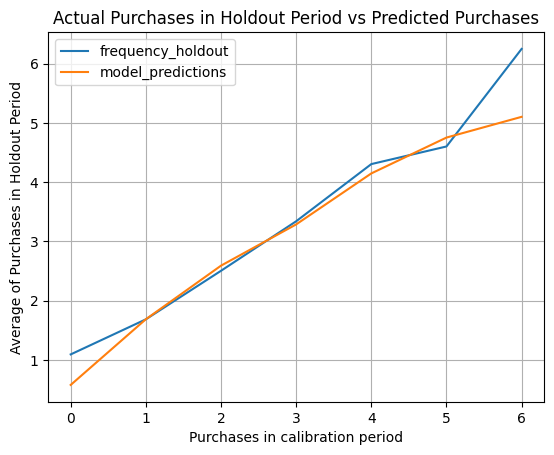

In [37]:
# Generate the plot
ax = plot_calibration_purchases_vs_holdout_purchases(model, df_rfmt_cal)

# Add grid to the plot
ax.grid(True)  # Enables the grid


plt.show()

In [38]:
df_rfmt = df_rfmt.reset_index()

In [39]:
df_rfmt['frequency']

0         0.0
1        10.0
2       113.0
3         3.0
4         3.0
        ...  
3916      0.0
3917      0.0
3918      1.0
3919     13.0
3920      2.0
Name: frequency, Length: 3921, dtype: float64

In [40]:

df_rfmt['prob_alive'] = model.conditional_probability_alive(df_rfmt['frequency'], df_rfmt['recency'], df_rfmt['T'])
df_rfmt

,index,CustomerID,frequency,recency,T,monetary_value,prob_alive
0,0,12346.0,0.0,0.0,325.0,0.000000,1.0
1,1,12747.0,10.0,367.0,369.0,383.745000,1.0
2,2,12748.0,113.0,373.0,373.0,298.360885,1.0
3,3,12749.0,3.0,210.0,213.0,1077.260000,1.0
4,4,12820.0,3.0,323.0,326.0,257.293333,1.0
...,...,...,...,...,...,...,...
3916,3916,18280.0,0.0,0.0,277.0,0.000000,1.0
3917,3917,18281.0,0.0,0.0,180.0,0.000000,1.0
3918,3918,18282.0,1.0,119.0,126.0,77.840000,1.0
3919,3919,18283.0,13.0,334.0,337.0,152.802308,1.0


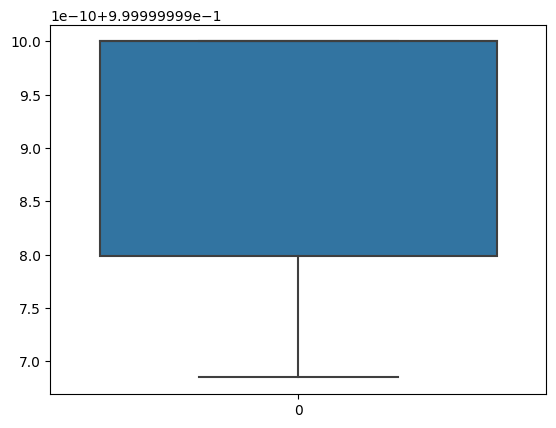

In [43]:
# create boxplot for the probability of being alive 
sns.boxplot(df_rfmt['prob_alive'])
plt.show()


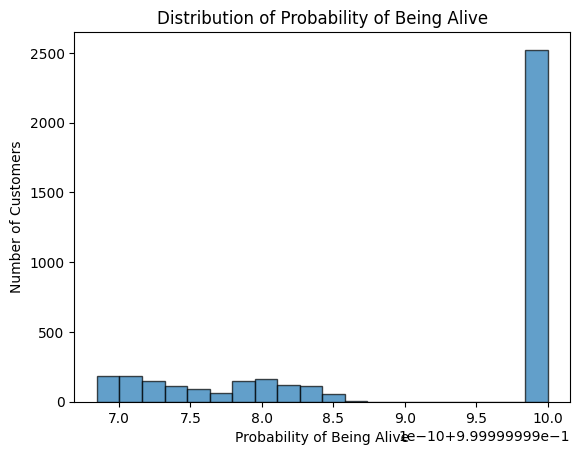

In [41]:
import matplotlib.pyplot as plt

# Histogram of probabilities
plt.hist(df_rfmt['prob_alive'], bins=20, alpha=0.7, edgecolor='k')
plt.title('Distribution of Probability of Being Alive')
plt.xlabel('Probability of Being Alive')
plt.ylabel('Number of Customers')
plt.show()


### Gamma-Gamma to predict the CLV

In [75]:
# Predicting the number of purchases in the next 180 days for all customers.
df_rfmt['predicted_purchases'] = model.conditional_expected_number_of_purchases_up_to_time(180, 
                                                                                      df_rfmt['frequency'], 
                                                                                      df_rfmt['recency'], 
                                                                                      df_rfmt['T'])
df_rfmt.dropna(inplace=True)
# Getting rid of negative values.
df_rfmt = df_rfmt[df_rfmt['monetary_value']>0]
df_rfmt

c:\Users\Zak\anaconda3\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
12747.0,10.0,367.0,369.0,383.745000,4.724260
12748.0,113.0,373.0,373.0,298.360885,51.506565
12749.0,3.0,210.0,213.0,1077.260000,2.507151
12820.0,3.0,323.0,326.0,257.293333,1.695147
12822.0,1.0,17.0,87.0,257.980000,2.105752
...,...,...,...,...,...
18272.0,5.0,244.0,246.0,487.752000,3.538257
18273.0,2.0,255.0,257.0,76.500000,1.469942
18282.0,1.0,119.0,126.0,77.840000,1.554281


In [76]:
# Fitting the GammaGamma model 

gg_model = GammaGammaFitter()
gg_model.fit(df_rfmt['frequency'], df_rfmt['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 2522 subjects, p: 2.08, q: 3.79, v: 526.58>

In [77]:
df_rfmt['pred_monetary'] = gg_model.conditional_expected_average_profit(
        df_rfmt['frequency'],
        df_rfmt['monetary_value'])
df_rfmt

,frequency,recency,T,monetary_value,predicted_purchases,pred_monetary
CustomerID,,,,,,
12747.0,10.0,367.0,369.0,383.745000,4.724260,384.781117
12748.0,113.0,373.0,373.0,298.360885,51.506565,299.465481
12749.0,3.0,210.0,213.0,1077.260000,2.507151,865.664823
12820.0,3.0,323.0,326.0,257.293333,1.695147,299.074601
12822.0,1.0,17.0,87.0,257.980000,2.105752,335.054152
...,...,...,...,...,...,...
18272.0,5.0,244.0,246.0,487.752000,3.538257,467.601977
18273.0,2.0,255.0,257.0,76.500000,1.469942,203.369918
18282.0,1.0,119.0,126.0,77.840000,1.554281,258.123378


In [78]:
# Predicting the CLV.
df_rfmt['CLV'] = gg_model.customer_lifetime_value(
    model,
    df_rfmt['frequency'],
    df_rfmt['recency'],
    df_rfmt['T'],
    df_rfmt['monetary_value'],
    time = 6,# In months 
    )
df_rfmt 

,frequency,recency,T,monetary_value,predicted_purchases,pred_monetary,CLV
CustomerID,,,,,,,
12747.0,10.0,367.0,369.0,383.745000,4.724260,384.781117,1755.842090
12748.0,113.0,373.0,373.0,298.360885,51.506565,299.465481,14898.661392
12749.0,3.0,210.0,213.0,1077.260000,2.507151,865.664823,2096.371453
12820.0,3.0,323.0,326.0,257.293333,1.695147,299.074601,489.694049
12822.0,1.0,17.0,87.0,257.980000,2.105752,335.054152,681.490913
...,...,...,...,...,...,...,...
18272.0,5.0,244.0,246.0,487.752000,3.538257,467.601977,1598.098696
18273.0,2.0,255.0,257.0,76.500000,1.469942,203.369918,288.751880
18282.0,1.0,119.0,126.0,77.840000,1.554281,258.123378,387.520705


### Customer Segmentation using k-Means

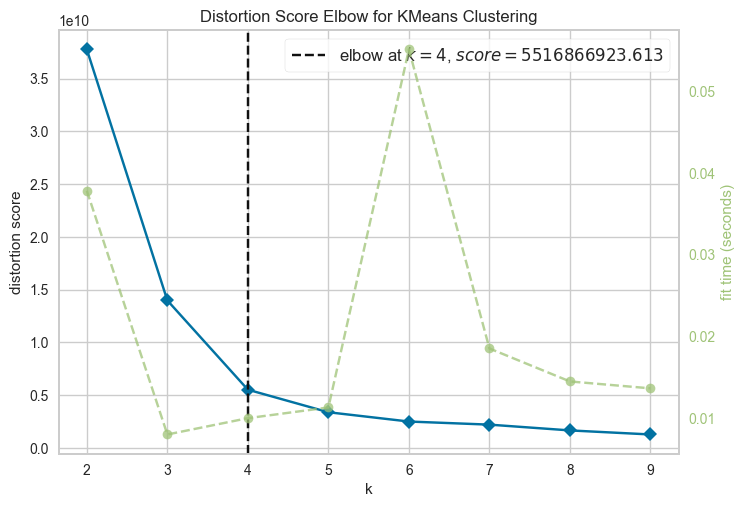

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [79]:
from yellowbrick.cluster import KElbowVisualizer


# Instantiate the clustering model and visualizer
km_model = KMeans()
visualizer = KElbowVisualizer(km_model, k=(2,10))

visualizer.fit(df_rfmt)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [80]:
km_model = KMeans(n_clusters=4)
km_model.fit(df_rfmt)
# Creating a new column called cluster whose values are the corresponding cluster for each point.
df_rfmt['cluster'] = km_model.labels_

In [81]:
# Grouping by clusters
df_clusters = df_rfmt.groupby(['cluster'])['CLV']\
                     .agg(['mean', "count"])\
                     .reset_index()

df_clusters.columns = ["cluster", "avg_CLV", "n_customers"]

df_clusters['perct_customers'] = (df_clusters['n_customers']/df_clusters['n_customers']\
                                  .sum())*100
df_clusters 

,cluster,avg_CLV,n_customers,perct_customers
0,0,1048.695553,2493,98.850119
1,1,70792.135090,1,0.039651
2,2,89859.022711,3,0.118953
3,3,19421.486294,25,0.991277


In [85]:
df_rfmt['customer_category'] = df_rfmt['cluster']\
.replace({1:"Gold", 2:"Diamond", 3:"Silver", 0:"Bronze"})

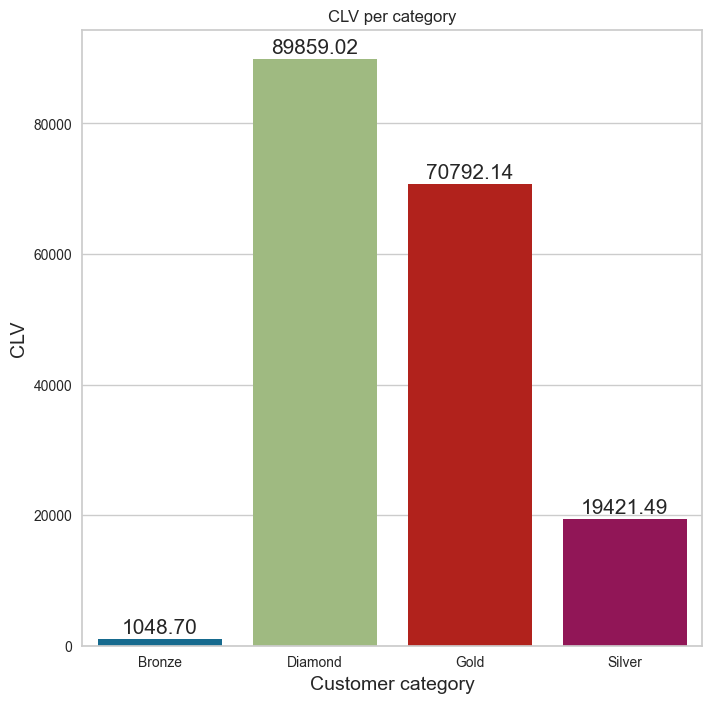

In [86]:
# Grouping by customer category
df_cat = pd.DataFrame(df_rfmt.groupby(['customer_category'])['CLV']\
                      .agg('mean')).reset_index()


# Code source : https://www.geeksforgeeks.org/how-to-annotate-bars-in-barplot-with-matplotlib-in-python/
# Defining the plot size
plt.figure(figsize=(8, 8))
 
# Defining the values for x-axis, y-axis
# and from which dataframe the values are to be picked
plots = sns.barplot(x="customer_category", y="CLV", data=df_cat)
 
# Iterating over the bars one-by-one
for bar in plots.patches:
   
  # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),textcoords='offset points')

plt.xlabel("Customer category", size=14)
 
# Setting the label for y-axis
plt.ylabel("CLV", size=14)
 
# Setting the title for the graph
plt.title("CLV per category")
 
# Finally showing the plot
plt.show()

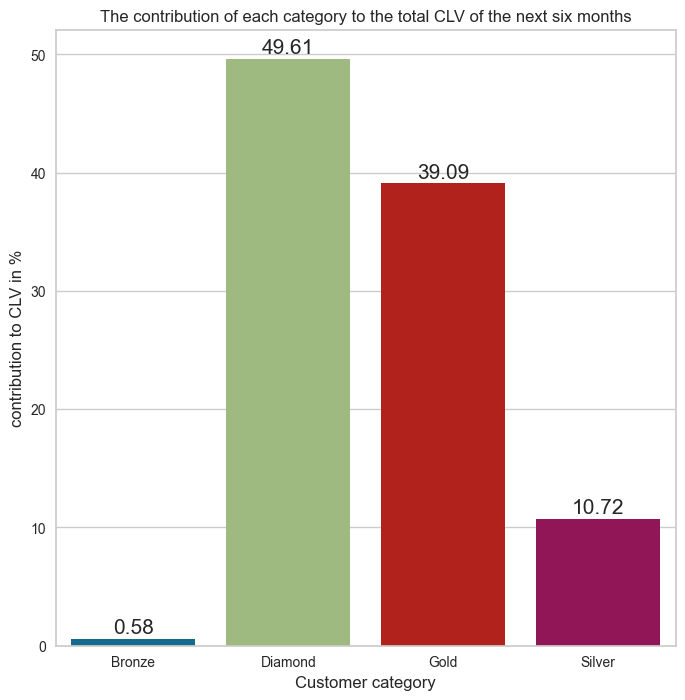

In [87]:
df_cat["contribution_to_CLV"] = df_cat['CLV']/df_cat['CLV'].sum()*100

# Code source : https://www.geeksforgeeks.org/how-to-annotate-bars-in-barplot-with-matplotlib-in-python/
# Defining the plot size
plt.figure(figsize=(8, 8))
 
# Defining the values for x-axis, y-axis
# and from which dataframe the values are to be picked
plots = sns.barplot(x="customer_category", y="contribution_to_CLV", data=df_cat)
 
# Iterating over the bars one-by-one
for bar in plots.patches:
   
  # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),textcoords='offset points')

plt.xlabel("Customer category", size=12)

# Setting the label for y-axis
plt.ylabel("contribution to CLV in %", size=12)
 
# Setting the title for the graph
plt.title("The contribution of each category to the total CLV of the next six months")
 
# Finally showing the plot
plt.show()

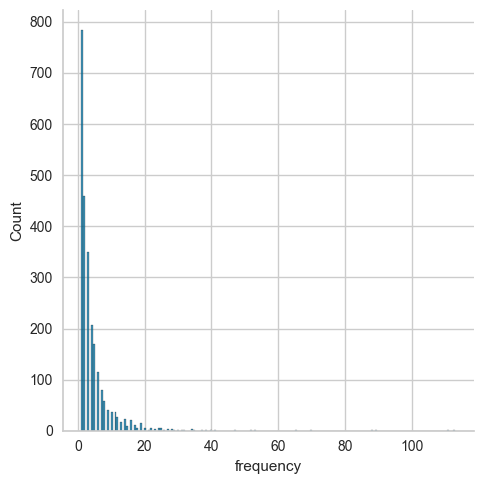

In [88]:
sns.displot(df_rfmt['frequency'])
plt.show()

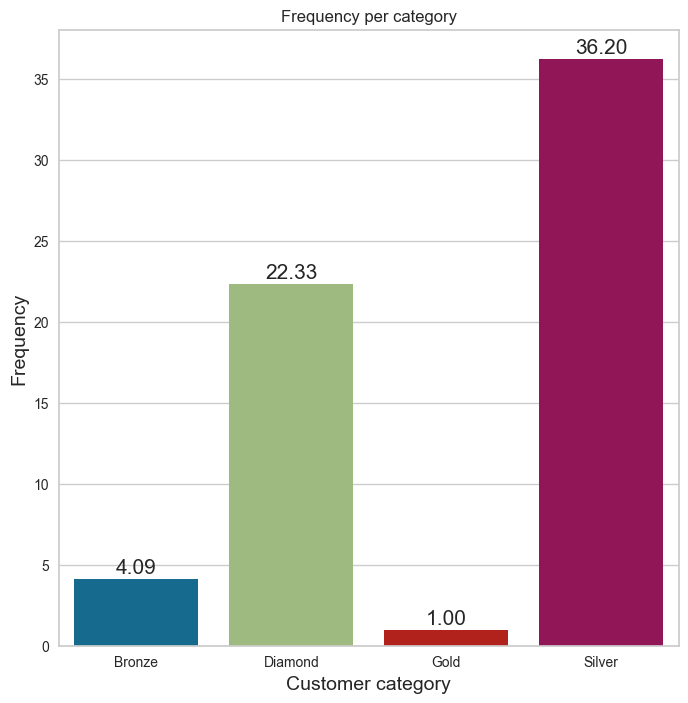

In [89]:
df_freq = pd.DataFrame(df_rfmt.groupby(['customer_category'])['frequency']\
                              .mean()\
                              .reset_index())


# Code source : https://www.geeksforgeeks.org/how-to-annotate-bars-in-barplot-with-matplotlib-in-python/
# Defining the plot size
plt.figure(figsize=(8, 8))
 
# Defining the values for x-axis, y-axis
# and from which dataframe the values are to be picked
plots = sns.barplot(x="customer_category", y="frequency", data=df_freq)
 
# Iterating over the bars one-by-one
for bar in plots.patches:
   
  # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),textcoords='offset points')

plt.xlabel("Customer category", size=14)
 
# Setting the label for y-axis
plt.ylabel("Frequency", size=14)
 
# Setting the title for the graph
plt.title("Frequency per category")
 
# Finally showing the plot
plt.show()